# Twitter cleaning
- First, we import the necessary packages to carry out the data cleaning

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import tweepy
from textblob import TextBlob
import nltk 

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

#Reading the file
df = pd.read_csv('tweets_amsterdam.csv')

print(df.dtypes)
print(df['tweet_date'])

tweet_id        int64
tweet_text     object
tweet_date     object
tweet_name     object
latitude      float64
longitude     float64
OBJECTID        int64
dtype: object
0         2014-02-10
1         2014-02-10
2         2014-02-10
3         2014-02-10
4         2014-02-10
             ...    
516869    2014-02-10
516870    2014-02-10
516871    2014-02-10
516872    2014-02-10
516873    2014-02-10
Name: tweet_date, Length: 516874, dtype: object


- We check the first lines of the file

In [2]:
df.head()

,tweet_id,tweet_text,tweet_date,tweet_name,latitude,longitude,OBJECTID
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,2014-02-10,improperbabs,52.376285,4.882352,24
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,2014-02-10,doriana_v,52.378130,4.893132,30
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,2014-02-10,soundloop,52.362261,4.882822,51
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,2014-02-10,soundloop,52.362261,4.882822,52
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,2014-02-10,HollyHolham,52.373585,4.897867,62


- We check the shape of the dataframe (rows and columns)

In [3]:
df.shape

(516874, 7)

CLEANING

- We delete duplicate tweets and check the shape again. Apparently, there are no duplicates.

In [4]:
df.drop_duplicates(inplace = True)
df.shape

(516874, 7)

- We create a new column "tweet_date" without the "-" from "tweet_date" to harmonize the date columns from the weather and the twitter datasets so that merging is more easily later.

In [5]:
df['tweet_dates'] = df['tweet_date'].str.replace('-', '')
print(df['tweet_dates'])

0         20140210
1         20140210
2         20140210
3         20140210
4         20140210
            ...   
516869    20140210
516870    20140210
516871    20140210
516872    20140210
516873    20140210
Name: tweet_dates, Length: 516874, dtype: object


- Split the dates into 3 new columns: "year", "month" and "day"

In [6]:
df[['year','month','day']] = df['tweet_date'].str.split('-', expand=True)

df.drop(columns='tweet_date',inplace=True)

print(df.dtypes)

tweet_id         int64
tweet_text      object
tweet_name      object
latitude       float64
longitude      float64
OBJECTID         int64
tweet_dates     object
year            object
month           object
day             object
dtype: object


- We check the dataframe for missing data (NA values). We found  20.621 missing values in the "tweet_name" column.

In [7]:
print(df['tweet_id'].isna().sum())
print(df['tweet_text'].isna().sum())
print(df['year'].isna().sum())
print(df['day'].isna().sum())
print(df['month'].isna().sum())
print(df['tweet_name'].isna().sum())
print(df['latitude'].isna().sum())
print(df['longitude'].isna().sum())

0
0
0
0
0
20621
0
0


- As tweet_date was an object, so are the columns created from it: "year", "month" and "day". Therefore, we transform them to integers.

In [8]:
#change objects to numbers
date = ['year','month','day']
for d in date:
  df[d]= (pd.to_numeric(df[d]))
  df[d] = df[d].astype('int64')
df.dtypes

tweet_id         int64
tweet_text      object
tweet_name      object
latitude       float64
longitude      float64
OBJECTID         int64
tweet_dates     object
year             int64
month            int64
day              int64
dtype: object

- We create a function called "cleanTxt" to remove "@mentions", "#" hashtags, "RT" retweets and hyperlinks from the "tweet_clean" column and create a new column called "cleanTxt" with the changes.

In [10]:
def cleanTxt(text):
     text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
     text = re.sub('#', '', text) # Removing '#' hash tag
     text = re.sub('RT[\s]+', '', text) # Removing RT
     text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
     return text
    
df['cleanTxt'] = df['tweet_text'].apply(cleanTxt)
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at )
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...


- Import and show the punctuation signs that we want to remove

In [9]:
import string
result=string.punctuation
print(result)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


- We create a function called "remove_punct" to remove all punctuations signs that have not been removed yet. We use the re.sub() function to remove numbers and signs from the text and the join() function to join characters that are not in the string punctuation list. We create, from "cleanTxt", a column called "Tweet_punct" with the above modifications.

In [11]:
#In re.sub(), specify a regular expression pattern in the first argument, a new string in the second argument, and a string to be processed in the third argument.
#When using join(), the characters just before the dot (i.e. "".join()) comprise the string separator that will join the terms to be joined. If there is nothing within the quotation marks (i.e. ""), it means that characters will be joined with no separator.
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['Tweet_punct'] = df['cleanTxt'].apply(lambda x: remove_punct(x))
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...


- We import the package "detect" from the library "langdetect" to identify in which language is written each tweet.

In [12]:
from langdetect import detect

In [13]:
#import of regular expressions engine for Python
import re

#just for the progress bar
from IPython.display import clear_output

#This is just a procedure to display a progress bar
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.4f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)
    
#This procedure removes non ascii and url from the tweets
#It uses regular expresions to process strings
def CleanaBit(rawTweetText): 
    onlyAscii = re.sub(r'[^\x00-\x7f]',r'', rawTweetText) 
    urlsInText = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', onlyAscii) 
    for u in urlsInText:
        dummy = onlyAscii.replace(u, '')
        onlyAscii = dummy
    return onlyAscii

#This stores the total number of rows in the df to feed in the progress bar
number_of_elements = df.shape[0]

# There will be an extra column in the dataframe showing the language in which each tweet is written. 
# I used a 'try' 'except' construction to catch errors trown by the detect algoritm. Most errors occurs when there are urls only in the
# tweet and/or non ascii characters. The detect algoritm automatically removes this resulting in an empty string wich cannot be processed by 
# detect algoritm, hence the errors. Now if an error is detected the df['langu'] columns will contain the message 'cannot detect'

# Currently it's a bit slow. You might consider not to call the CleanaBit procedure. This will invoke more errors 
# (since there will be more bad tweettext) probably and more tweets will not be processed. 

for index,row in df.iterrows():    
  tweetText = (row['tweet_text']) 
  cleanString = CleanaBit(tweetText)
  if cleanString:
      try:
          df.loc[index,'langu'] = detect(cleanString)
      except:
        print("foutje record nr: %s: %s" % (index,cleanString))
        df.loc[index,'langu'] = "cannot_detect"
  update_progress(index / number_of_elements) 

Progress: [####################] 99.9998%


- We check the first heading of the dataframe to assess the result of the language detection procedure. As can be observed, an column called "langu" shows the language in which tweets are written.

In [14]:
# Checking the first lines of the file
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot,en
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at,nl
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...,en
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...,en
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...,en


We check the shape just to be sure that everything is as it should be.

In [15]:
# We check the shape of the dataframe (rows and columns)
df.shape

(516874, 13)

## PREPROCESSING 

### Tokenization
- We define a tokenization function by drawing on re.split() to split all words with commas, then we apply it with .apply(lanmbda x: tokenization(x.lower())). We run the function on "Tweet_punct" and store the results in a new column "Tweet_tokenized".

In [16]:
#Tokenization
#In re.split(), specify the regular expression pattern in the first parameter and the target character string in the second parameter.
def tokenization(text):
    text = re.split('\W+', text)
    return text

#The .apply(lanmbda x: tokenization(x.lower())) applies the tokenization function of the upper paragraph to the tweet_punct column.
df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot,en,"[, dutch, stamp, pot, ]"
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at,nl,"[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a..."
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...,en,"[remix, su, amp, hetm, boo, minutes, and, stil..."
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...,en,"[remix, erfi, of, evlo, various, casino, light..."
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...,en,"[, cant, wait, to, get, home, and, shove, one,..."


Stopwords
- We set the languages from which we want to remove stopwords (commonly used words that a search engine has been programmed to ignore) from our tweets by using NLTK stored lists of words.

In [17]:
#THESE ARE THE LANGUAGES FROM WHICH I AM GOING TO REMOVE WORDS IN THE TWEETS
stopword = nltk.corpus.stopwords.words('english')
stopword = nltk.corpus.stopwords.words('dutch')
stopword = nltk.corpus.stopwords.words('spanish')
stopword = nltk.corpus.stopwords.words('turkish')
stopword = nltk.corpus.stopwords.words('german')

- We define the function "remove_stopwords", apply it on the "Tweet_tokenized" column and store the results in the "Tweet_nonstop" column.

In [18]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot,en,"[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]"
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at,nl,"[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a..."
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...,en,"[remix, su, amp, hetm, boo, minutes, and, stil...","[remix, su, amp, hetm, boo, minutes, and, stil..."
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...,en,"[remix, erfi, of, evlo, various, casino, light...","[remix, erfi, of, evlo, various, casino, light..."
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...,en,"[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,..."


### Stemming & Lemmatization
- Text Normalization techniques used to prepare text for further processing.
    - Stemming is the process of reducing inflection in words to their root forms, even if the stem is not a valid word.
    - Lemmatizing reduces the inflected word properly, ensuring that the root word (lemma) belongs to the language.
    
- Only English words will be stemmed and lemmatized (as they are the only ones we will need at the end).

- Stemming is performed on "Tweet_nonstop" and results are stored in "Tweet_stemmed".

In [19]:
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot,en,"[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]"
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at,nl,"[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a..."
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...,en,"[remix, su, amp, hetm, boo, minutes, and, stil...","[remix, su, amp, hetm, boo, minutes, and, stil...","[remix, su, amp, hetm, boo, minut, and, still,..."
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...,en,"[remix, erfi, of, evlo, various, casino, light...","[remix, erfi, of, evlo, various, casino, light...","[remix, erfi, of, evlo, variou, casino, light,..."
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...,en,"[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,..."


- Lemmatizing is performed on "Tweet_nonstop" and results are stored in "lemmatized".

In [20]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))

df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,432871538619338752,@CafeSonneveld Dutch stamp pot. http://t.co/XH...,improperbabs,52.376285,4.882352,24,20140210,2014,2,10,Dutch stamp pot.,Dutch stamp pot,en,"[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]","[, dutch, stamp, pot, ]"
1,432871597138276353,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at @DePoez...,doriana_v,52.378130,4.893132,30,20140210,2014,2,10,Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð²! (at ),Ð“Ð»Ð°Ð´Ð¸Ñ‚ÑŒ ÐºÐ¾Ð¾Ð¾Ñ‚Ð¸ÐºÐ¾Ð² at,nl,"[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a...","[ð, ð, ð, ð, ð, ñ, ñœ, ðºð¾ð¾ð¾ñ, ð, ðºð¾ð², a..."
2,432871783318827008,#ReMix su &amp hetm Boo! 15 minutes and still ...,soundloop,52.362261,4.882822,51,20140210,2014,2,10,ReMix su &amp hetm Boo! 15 minutes and still n...,ReMix su amp hetm Boo minutes and still no co...,en,"[remix, su, amp, hetm, boo, minutes, and, stil...","[remix, su, amp, hetm, boo, minutes, and, stil...","[remix, su, amp, hetm, boo, minut, and, still,...","[remix, su, amp, hetm, boo, minute, and, still..."
3,432871785881546752,#ReMix [erfi of evlo] various - casino lights ...,soundloop,52.362261,4.882822,52,20140210,2014,2,10,ReMix [erfi of evlo] various - casino lights '...,ReMix erfi of evlo various casino lights poi...,en,"[remix, erfi, of, evlo, various, casino, light...","[remix, erfi, of, evlo, various, casino, light...","[remix, erfi, of, evlo, variou, casino, light,...","[remix, erfi, of, evlo, various, casino, light..."
4,432871839845871616,@KWyeah can''t wait to get home and shove one ...,HollyHolham,52.373585,4.897867,62,20140210,2014,2,10,can''t wait to get home and shove one in me e...,cant wait to get home and shove one in me ear...,en,"[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,...","[, cant, wait, to, get, home, and, shove, one,..."


- Values are stored in ascending order by the tweets´ dates.

In [21]:
df = df.sort_values(by='tweet_dates',ascending=True)
df.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
394496,397739168895225857,#ReMix ditlaam rsteue Boo! 15 minutes and stil...,NaN,52.362261,4.882822,13826908,20131105,2013,11,5,ReMix ditlaam rsteue Boo! 15 minutes and still...,ReMix ditlaam rsteue Boo minutes and still no...,en,"[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minut, and, stil...","[remix, ditlaam, rsteue, boo, minute, and, sti..."
387591,397752789621039105,Come for lunch (@ Bohemia Amsterdam - @bohemia...,NaN,52.371407,4.894270,13622455,20131105,2013,11,5,Come for lunch (@ Bohemia Amsterdam - ),Come for lunch Bohemia Amsterdam,en,"[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]"
387592,397752910312140800,@KarenvdHeijden omdat de linkse partijen falen...,NaN,52.376767,4.889508,13622476,20131105,2013,11,5,omdat de linkse partijen falen in de burgemee...,omdat de linkse partijen falen in de burgemee...,nl,"[, omdat, de, linkse, partijen, falen, in, de,...","[, omdat, de, linkse, partijen, falen, de, bur...","[, omdat, de, links, partijen, falen, de, burg...","[, omdat, de, linkse, partijen, falen, de, bur..."
387593,397752973822287872,"I''m at CafÃ© Papeneiland (Amsterdam, Noord-Ho...",NaN,52.380453,4.888296,13622489,20131105,2013,11,5,"I''m at CafÃ© Papeneiland (Amsterdam, Noord-Ho...",Im at CafÃ© Papeneiland Amsterdam NoordHolland,nl,"[im, at, cafã, papeneiland, amsterdam, noordho...","[at, cafã, papeneiland, amsterdam, noordhollan...","[at, cafã, papeneiland, amsterdam, noordhollan...","[at, cafã, papeneiland, amsterdam, noordhollan..."
387594,397752987344715776,"#ReMix answer: your bridge is burning, @Chelis...",NaN,52.362261,4.882822,13622490,20131105,2013,11,5,"ReMix answer: your bridge is burning, 22/2430...",ReMix answer your bridge is burning points,en,"[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridg, is, burn, point]","[remix, answer, your, bridge, is, burning, point]"


- We use the dataframe.loc attribute to access the rows with the "en" label within the "langu" column. We store the accessed data as "df2".

In [23]:
df2=df.loc[df['langu']=='en']
df2.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
394496,397739168895225857,#ReMix ditlaam rsteue Boo! 15 minutes and stil...,NaN,52.362261,4.882822,13826908,20131105,2013,11,5,ReMix ditlaam rsteue Boo! 15 minutes and still...,ReMix ditlaam rsteue Boo minutes and still no...,en,"[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minut, and, stil...","[remix, ditlaam, rsteue, boo, minute, and, sti..."
387591,397752789621039105,Come for lunch (@ Bohemia Amsterdam - @bohemia...,NaN,52.371407,4.894270,13622455,20131105,2013,11,5,Come for lunch (@ Bohemia Amsterdam - ),Come for lunch Bohemia Amsterdam,en,"[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]"
387594,397752987344715776,"#ReMix answer: your bridge is burning, @Chelis...",NaN,52.362261,4.882822,13622490,20131105,2013,11,5,"ReMix answer: your bridge is burning, 22/2430...",ReMix answer your bridge is burning points,en,"[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridg, is, burn, point]","[remix, answer, your, bridge, is, burning, point]"
387595,397752989567291392,#ReMix [lsrdoei oyb] the shirelles - the fabul...,NaN,52.362261,4.882822,13622491,20131105,2013,11,5,ReMix [lsrdoei oyb] the shirelles - the fabulo...,ReMix lsrdoei oyb the shirelles the fabulous ...,en,"[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirel, the, fabul,...","[remix, lsrdoei, oyb, the, shirelles, the, fab..."
387599,397753324709351425,at the #midtowngrill pre #thanksgiving #turkey...,NaN,52.362695,4.880609,13622559,20131105,2013,11,5,at the midtowngrill pre thanksgiving turkeytog...,at the midtowngrill pre thanksgiving turkeytog...,en,"[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngril, pre, thanksgiv, turkeyt...","[at, the, midtowngrill, pre, thanksgiving, tur..."


- We check the shape to ensure it has been done properly.

In [24]:
df2.shape

(235759, 17)

- We use word cloud viusalization to assess the words´ distribution in the tweets.

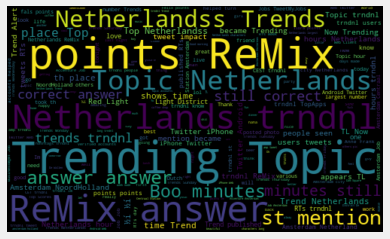

In [26]:
allWords = ' '.join([twts for twts in df2['Tweet_punct']])
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# SENTIMENT ANALYSIS

- In order to add the tweets´ subjectivity and polarity to the dataframe, we create two functions. "getsubjectivity" will determine how subjective the text is (a score of 0 is fact, and a score of +1 is an opinion) and "getpolarity" to determine the tweets´ polarity (how positive or negative the text is, (score of -1 is the highest negative score, and a score of +1 is the highest positive score).

- The results will be stored in two columns: "Subjectivity" and "Polarity".

In [25]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df2['Subjectivity'] = df2['Tweet_punct'].apply(getSubjectivity)
df2['Polarity'] = df2['Tweet_punct'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df2.head()

/Users/diegobb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/diegobb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,Subjectivity,Polarity
394496,397739168895225857,#ReMix ditlaam rsteue Boo! 15 minutes and stil...,NaN,52.362261,4.882822,13826908,20131105,2013,11,5,ReMix ditlaam rsteue Boo! 15 minutes and still...,ReMix ditlaam rsteue Boo minutes and still no...,en,"[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minut, and, stil...","[remix, ditlaam, rsteue, boo, minute, and, sti...",0.0,0.0
387591,397752789621039105,Come for lunch (@ Bohemia Amsterdam - @bohemia...,NaN,52.371407,4.894270,13622455,20131105,2013,11,5,Come for lunch (@ Bohemia Amsterdam - ),Come for lunch Bohemia Amsterdam,en,"[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]",0.0,0.0
387594,397752987344715776,"#ReMix answer: your bridge is burning, @Chelis...",NaN,52.362261,4.882822,13622490,20131105,2013,11,5,"ReMix answer: your bridge is burning, 22/2430...",ReMix answer your bridge is burning points,en,"[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridg, is, burn, point]","[remix, answer, your, bridge, is, burning, point]",0.0,0.0
387595,397752989567291392,#ReMix [lsrdoei oyb] the shirelles - the fabul...,NaN,52.362261,4.882822,13622491,20131105,2013,11,5,ReMix [lsrdoei oyb] the shirelles - the fabulo...,ReMix lsrdoei oyb the shirelles the fabulous ...,en,"[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirel, the, fabul,...","[remix, lsrdoei, oyb, the, shirelles, the, fab...",1.0,0.4
387599,397753324709351425,at the #midtowngrill pre #thanksgiving #turkey...,NaN,52.362695,4.880609,13622559,20131105,2013,11,5,at the midtowngrill pre thanksgiving turkeytog...,at the midtowngrill pre thanksgiving turkeytog...,en,"[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngril, pre, thanksgiv, turkeyt...","[at, the, midtowngrill, pre, thanksgiving, tur...",0.0,0.0


- Now, we create a function called "getAnalysis" to compute the negative (-1), neutral (0), and positive (+1) analysis, and add the information to a new column called Analysis.

In [27]:
def getAnalysis(score):
    
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
df2['Analysis'] = df2['Polarity'].apply(getAnalysis)

# Show the dataframe
df2.head()

/Users/diegobb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,Subjectivity,Polarity,Analysis
394496,397739168895225857,#ReMix ditlaam rsteue Boo! 15 minutes and stil...,NaN,52.362261,4.882822,13826908,20131105,2013,11,5,ReMix ditlaam rsteue Boo! 15 minutes and still...,ReMix ditlaam rsteue Boo minutes and still no...,en,"[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minut, and, stil...","[remix, ditlaam, rsteue, boo, minute, and, sti...",0.0,0.0,Neutral
387591,397752789621039105,Come for lunch (@ Bohemia Amsterdam - @bohemia...,NaN,52.371407,4.894270,13622455,20131105,2013,11,5,Come for lunch (@ Bohemia Amsterdam - ),Come for lunch Bohemia Amsterdam,en,"[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]",0.0,0.0,Neutral
387594,397752987344715776,"#ReMix answer: your bridge is burning, @Chelis...",NaN,52.362261,4.882822,13622490,20131105,2013,11,5,"ReMix answer: your bridge is burning, 22/2430...",ReMix answer your bridge is burning points,en,"[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridg, is, burn, point]","[remix, answer, your, bridge, is, burning, point]",0.0,0.0,Neutral
387595,397752989567291392,#ReMix [lsrdoei oyb] the shirelles - the fabul...,NaN,52.362261,4.882822,13622491,20131105,2013,11,5,ReMix [lsrdoei oyb] the shirelles - the fabulo...,ReMix lsrdoei oyb the shirelles the fabulous ...,en,"[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirel, the, fabul,...","[remix, lsrdoei, oyb, the, shirelles, the, fab...",1.0,0.4,Positive
387599,397753324709351425,at the #midtowngrill pre #thanksgiving #turkey...,NaN,52.362695,4.880609,13622559,20131105,2013,11,5,at the midtowngrill pre thanksgiving turkeytog...,at the midtowngrill pre thanksgiving turkeytog...,en,"[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngril, pre, thanksgiv, turkeyt...","[at, the, midtowngrill, pre, thanksgiving, tur...",0.0,0.0,Neutral


- We print the percentage of positive tweets

In [ ]:
ptweets = df2[df2.Analysis == 'Positive']
ptweets = ptweets['Tweet_punct']
ptweets

round( (ptweets.shape[0] / df2.shape[0]) * 100 , 1)

- We print the percentage of negative tweets

In [29]:
ntweets = df2[df2.Analysis == 'Negative']
ntweets = ntweets['Tweet_punct']
ntweets

round( (ntweets.shape[0] / df2.shape[0]) * 100, 1)

9.1

- We show the value counts

In [30]:
df2['Analysis'].value_counts()

Neutral     138371
Positive     75951
Negative     21437
Name: Analysis, dtype: int64

- We plot and visualize the counts

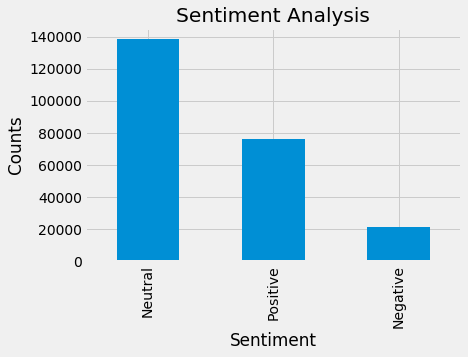

In [31]:
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df2['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

- We check the types to see if everything is as it should

In [35]:
df2.dtypes

tweet_id              int64
tweet_text           object
tweet_name           object
latitude            float64
longitude           float64
OBJECTID              int64
tweet_dates          object
year                  int64
month                 int64
day                   int64
cleanTxt             object
Tweet_punct          object
langu                object
Tweet_tokenized      object
Tweet_nonstop        object
Tweet_stemmed        object
Tweet_lemmatized     object
Subjectivity        float64
Polarity            float64
Analysis             object
dtype: object

- We store the dataframe as a csv file

In [33]:
df2.to_csv('cleaningdf.csv')

In [36]:
df2['latitude'] = df['latitude'].astype('int64')
df2.dtypes

/Users/diegobb/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


tweet_id              int64
tweet_text           object
tweet_name           object
latitude              int64
longitude           float64
OBJECTID              int64
tweet_dates          object
year                  int64
month                 int64
day                   int64
cleanTxt             object
Tweet_punct          object
langu                object
Tweet_tokenized      object
Tweet_nonstop        object
Tweet_stemmed        object
Tweet_lemmatized     object
Subjectivity        float64
Polarity            float64
Analysis             object
dtype: object

In [38]:
df2.head()

,tweet_id,tweet_text,tweet_name,latitude,longitude,OBJECTID,tweet_dates,year,month,day,cleanTxt,Tweet_punct,langu,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized,Subjectivity,Polarity,Analysis
394496,397739168895225857,#ReMix ditlaam rsteue Boo! 15 minutes and stil...,NaN,52,4.882822,13826908,20131105,2013,11,5,ReMix ditlaam rsteue Boo! 15 minutes and still...,ReMix ditlaam rsteue Boo minutes and still no...,en,"[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minutes, and, st...","[remix, ditlaam, rsteue, boo, minut, and, stil...","[remix, ditlaam, rsteue, boo, minute, and, sti...",0.0,0.0,Neutral
387591,397752789621039105,Come for lunch (@ Bohemia Amsterdam - @bohemia...,NaN,52,4.894270,13622455,20131105,2013,11,5,Come for lunch (@ Bohemia Amsterdam - ),Come for lunch Bohemia Amsterdam,en,"[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]","[come, for, lunch, bohemia, amsterdam, ]",0.0,0.0,Neutral
387594,397752987344715776,"#ReMix answer: your bridge is burning, @Chelis...",NaN,52,4.882822,13622490,20131105,2013,11,5,"ReMix answer: your bridge is burning, 22/2430...",ReMix answer your bridge is burning points,en,"[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridge, is, burning, poi...","[remix, answer, your, bridg, is, burn, point]","[remix, answer, your, bridge, is, burning, point]",0.0,0.0,Neutral
387595,397752989567291392,#ReMix [lsrdoei oyb] the shirelles - the fabul...,NaN,52,4.882822,13622491,20131105,2013,11,5,ReMix [lsrdoei oyb] the shirelles - the fabulo...,ReMix lsrdoei oyb the shirelles the fabulous ...,en,"[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirelles, the, fab...","[remix, lsrdoei, oyb, the, shirel, the, fabul,...","[remix, lsrdoei, oyb, the, shirelles, the, fab...",1.0,0.4,Positive
387599,397753324709351425,at the #midtowngrill pre #thanksgiving #turkey...,NaN,52,4.880609,13622559,20131105,2013,11,5,at the midtowngrill pre thanksgiving turkeytog...,at the midtowngrill pre thanksgiving turkeytog...,en,"[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngrill, pre, thanksgiving, tur...","[at, the, midtowngril, pre, thanksgiv, turkeyt...","[at, the, midtowngrill, pre, thanksgiving, tur...",0.0,0.0,Neutral


- We had some problems with the language detection code and we ended up needing Arend´s help with it. As for the tokenization and other processing methods which we ended up not making use of, we take the knowledge gained from having worked with them.